# Вычислительная математика. Домашняя лабораторная работа №4. Тема: "Интерполяция".
## Выполнил: Хайдари Фарид, группа Б01-909.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp

# Определим глобальные константы

In [2]:
popUSA = {
    1910: 92_228_496,
    1920: 106_021_537,
    1930: 123_202_624,
    1940: 132_164_569,
    1950: 151_325_798,
    1960: 179_323_175,
    1970: 203_211_926,
    1980: 226_545_805,
    1990: 248_709_873,
    2000: 281_421_906
}

yrs = list(popUSA.keys())
pop = list(popUSA.values())

popUSA2010 = 308_745_538

fsz = (20, 10)


# Определим функции для интерполяционного полинома в форме Ньютона

In [3]:
# Возвращает таблицу разделенных разностей
def dividedDiff(x, y):
    n = len(y)
    coef = np.zeros([n, n])
    # the first column is y
    coef[:, 0] = y

    for j in range(1, n):
        for i in range(n-j):
            coef[i][j] = (coef[i + 1][j - 1] - coef[i][j - 1]) \
                / (x[i + j] - x[i])

    return coef

# Возвращает значение полинома ньютона в точке x
def newtonPoly(coef, x_data, x):
    n = len(x_data) - 1
    p = coef[n]
    for k in range(1, n + 1):
        p = coef[n - k] + (x - x_data[n - k]) * p
    return p


## Построим интерполяционный многочлен в форме Ньютона

In [4]:
newtonCoeffsTable = dividedDiff(yrs, pop)
newtonCoeffs = newtonCoeffsTable[0, :]

pd.DataFrame(newtonCoeffsTable) # распечатаем таблицу коэффициентов

,0,1,2,3,4,5,6,7,8,9
0,92228496.0,1379304.1,16940.230,-1934.531333,125.106725,-4.150598,0.080565,-0.000756,-0.000008,5.099328e-07
1,106021537.0,1718108.7,-41095.710,3069.737667,-82.423175,0.683327,0.027611,-0.001362,0.000038,0.000000e+00
2,123202624.0,896194.5,50996.420,-227.189333,-48.256825,2.340014,-0.067705,0.001705,0.000000,0.000000e+00
3,132164569.0,1916122.9,44180.740,-2157.462333,68.743867,-1.722268,0.051623,0.000000,0.000000,0.000000e+00
4,151325798.0,2799737.7,-20543.130,592.292333,-17.369554,1.375117,0.000000,0.000000,0.000000,0.000000e+00
5,179323175.0,2388875.1,-2774.360,-102.489833,51.386312,0.000000,0.000000,0.000000,0.000000,0.000000e+00
6,203211926.0,2333387.9,-5849.055,1952.962667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
7,226545805.0,2216406.8,52739.825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
8,248709873.0,3271203.3,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
9,281421906.0,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


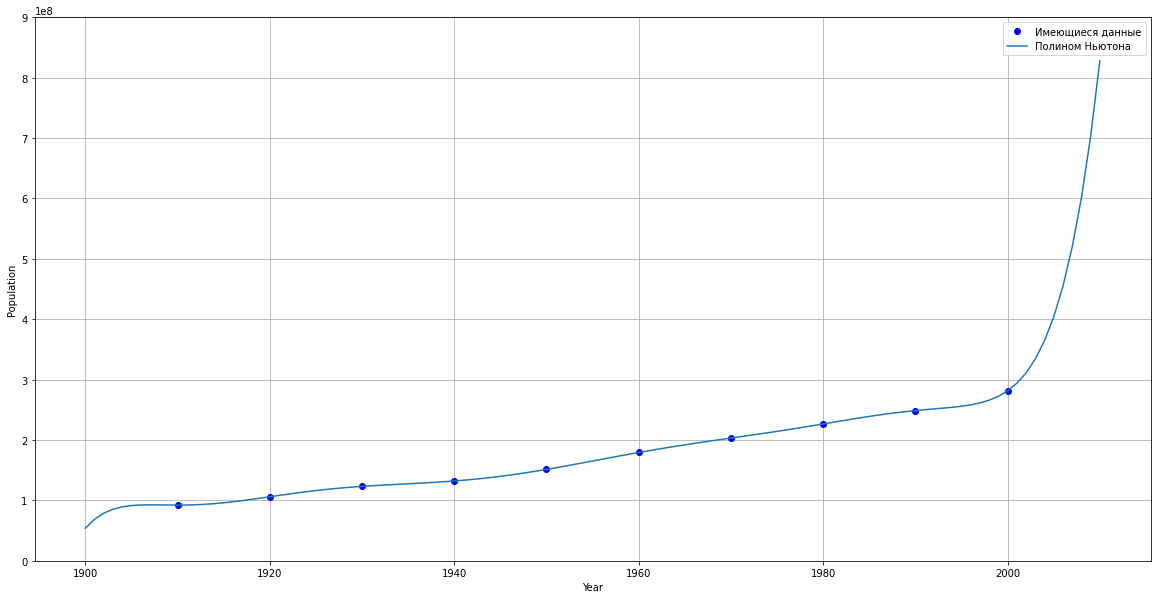

In [5]:
x1 = np.arange(yrs[0] - 10, yrs[-1] + 11, 1) # from 1900 to 2010
y1 = newtonPoly(newtonCoeffs, yrs, x1)

plt.figure(figsize=fsz)
plt.xlabel('Year')
plt.ylabel('Population')
plt.ylim((0, 9e8))
plt.grid()

plt.plot(yrs, pop, 'bo', label='Имеющиеся данные')
plt.plot(x1, y1, label='Полином Ньютона')

plt.legend()
plt.show()

## Рассчитаем население США на 2010 год с помощью полученного интерполяционного полинома.
## Сравним с реальными значениями

In [6]:
calcPop1 = int(y1[2010 - (yrs[0] - 10)])
print(f'Вычисленное население США в 2010: {calcPop1:,}')
print(f'Реальное население США в 2010:    {popUSA2010:,}')


Вычисленное население США в 2010: 827,906,509
Реальное население США в 2010:    308,745,538


# Определим методы для построения сплайн интерполяции

In [7]:
class Spline:
    def __init__(self, a, b, c, d, x):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.x = x # узел сетки


def solveSystem(splines, x, y):
    assert len(x) == len(y), 'x and y should have same length'
    n = len(x)

    # Решение СЛАУ относительно коэффициентов сплайнов c[i]. Прямой ход
    alpha = [0.0 for i in range(0, n - 1)]
    beta = [0.0 for i in range(0, n - 1)]

    for i in range(1, n - 1):
        hi = x[i] - x[i - 1]
        hi1 = x[i + 1] - x[i]
        A = hi
        C = 2.0 * (hi + hi1)
        B = hi1
        F = 6.0 * ((y[i + 1] - y[i]) / hi1 - (y[i] - y[i - 1]) / hi)
        z = (A * alpha[i - 1] + C)
        alpha[i] = -B / z
        beta[i] = (F - A * beta[i - 1]) / z

    # Обратный ход
    for i in range(n - 2, 0, -1):
        splines[i].c = alpha[i] * splines[i + 1].c + beta[i]

    return splines


def buildSpline(x, y):
    assert len(x) == len(y), 'x and y should have same length'
    n = len(x)

    splines = [Spline(0, 0, 0, 0, 0) for i in range(0, n)]
    for i in range(0, n):
        splines[i].x = x[i]
        splines[i].a = y[i]

    # Задаём доп условие
    splines[0].c = splines[n - 1].c = 0.0
    splines = solveSystem(splines, x, y)

    # По известным коэффициентам c[i] находим значения b[i] и d[i]
    for i in range(n - 1, 0, -1):
        hi = x[i] - x[i - 1]
        splines[i].d = (splines[i].c - splines[i - 1].c) / hi
        splines[i].b = hi * (2.0 * splines[i].c +
                             splines[i - 1].c) / 6.0 + (y[i] - y[i - 1]) / hi
    return splines


# Бин. поиск нужного отрезка
def findInterval(splines, x):
    n = len(splines)
    i = 0
    j = n - 1

    while i + 1 < j:
        k = i + (j - i) // 2
        if x <= splines[k].x:
            j = k
        else:
            i = k

    return splines[j]


# Вычисление значения интерполированной функции в произвольной точке
def interpolate(splines, x):
    assert splines, 'splines is not built'

    n = len(splines)
    s = Spline(0, 0, 0, 0, 0)

    if x <= splines[0].x:  # Если x меньше x[0] - берем первый элемент массива
        s = splines[0]
    elif x >= splines[n - 1].x:  # Если x больше x[n - 1] - берем последний
        s = splines[n - 1]
    else:  # Иначе ищем где x бин. поиском
        s = findInterval(splines, x)

    dx = x - s.x
    # Вычисляем значение сплайна в заданной точке по схеме Горнера
    return s.a + (s.b + (s.c / 2.0 + s.d * dx / 6.0) * dx) * dx


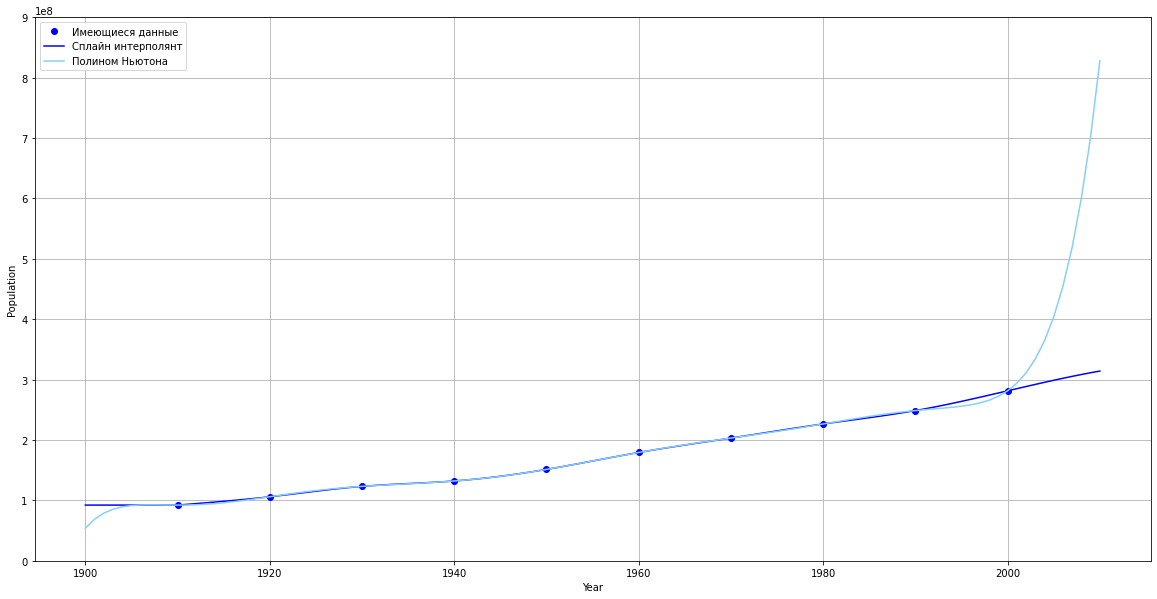

In [8]:
spline = buildSpline(yrs, pop)

x2 = x1
y2 = [interpolate(spline, x) for x in x2]

plt.figure(figsize=fsz)
plt.xlabel('Year')
plt.ylabel('Population')
plt.ylim((0, 9e8))
plt.grid()

plt.plot(yrs, pop, 'bo', label='Имеющиеся данные')
plt.plot(x2, y2, 'b', label='Сплайн интерполянт')
plt.plot(x1, y1, 'lightskyblue', label='Полином Ньютона')

plt.legend()
plt.show()


## Рассчитаем население США на 2010 год с помощью полученного интерполяционного полинома.
## Сравним с реальными значениями

In [9]:
calcPop2 = int(y2[2010 - (yrs[0] - 10)])
print(f'Вычисленное население США в 2010: {calcPop2:,}')
print(f'Реальное население США в 2010:    {popUSA2010:,}')

Вычисленное население США в 2010: 314,133,939
Реальное население США в 2010:    308,745,538


## Проверим результаты нашей сплайн-интерполяции с помощью numpy

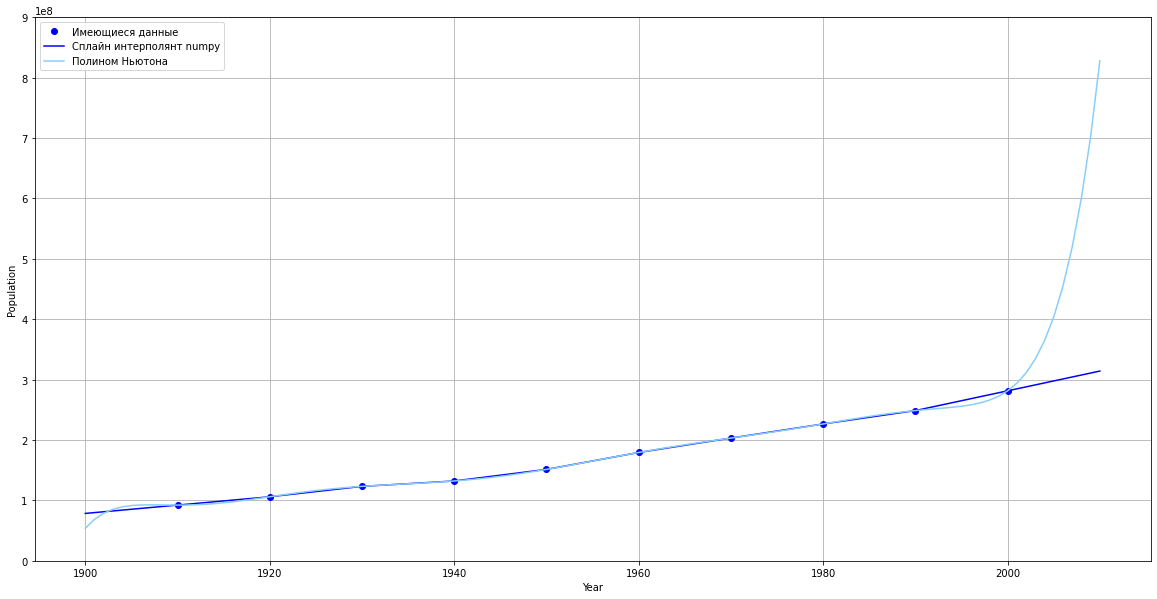

In [10]:
f = interp.interp1d(yrs, pop, fill_value='extrapolate')

x3 = x1
y3 = f(x3)

plt.figure(figsize=fsz)
plt.xlabel('Year')
plt.ylabel('Population')
plt.ylim((0, 9e8))
plt.grid()

plt.plot(yrs, pop, 'bo', label='Имеющиеся данные')
plt.plot(x3, y3, 'b', label='Сплайн интерполянт numpy')
plt.plot(x1, y1, 'lightskyblue', label='Полином Ньютона')

plt.legend()
plt.show()

In [11]:
calcPop3 = int(y3[2010 - (yrs[0] - 10)])
print(f'Вычисленное население США в 2010: {calcPop3:,}')
print(f'Реальное население США в 2010:    {popUSA2010:,}')

Вычисленное население США в 2010: 314,133,939
Реальное население США в 2010:    308,745,538
